Based on the

[1]: Kvanttia asuntokauppaan, O. Salmenkivi 2000, https://github.com/CSCfi/Quantum/blob/main/Finance-modelling/Kvanttia_asuntokauppaan.ipynb

***

# Predicting housing prices using Quantum amplitude estimation

In this example, we consider an extremely simplified model for the Finnish housing markets in Helsinki. We have data for the average price per square meter of the apartments in Helsinki for different postal codes and the annual price growth between the years 2010 and 2020. To predict the average price in the year 2021, we multiply the the mean values of the average prices and the annual growth rates. The calculation is trivial, but its main point is to serve as a demonstration of the Quantum amplitude estimation algorithm.

# Preparing data

### Imports

In [1]:
!pip install pyarrow   #Pandas dependencies

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute
from qiskit.extensions import UnitaryGate

pi=np.pi

Defaulting to user installation because normal site-packages is not writeable


### Domain

Depending on the data, we choose the domain most suitable for the linear approximation. 

In [2]:
def get_domain(data, approx, confidence):
    mean_value = np.mean(data)
    stddev = np.std(data)
    low = np.maximum(0, mean_value - confidence*stddev)
    high = mean_value + confidence*stddev
    minimum = np.min(data)
    maximum = np.max(data)
    if (approx == True):
        domain = [low, high]
    else:
        domain = [minimum, maximum]
    return domain

### Loading data

In [3]:
df_prices = pd.read_csv("housing_price_data.csv", sep=';', decimal=",", header=None)
df_growth = pd.read_csv("housing_growth_data.csv", sep=';', decimal=",", header=None)
price_data = df_prices.to_numpy()
growth_data = df_growth.to_numpy()

In [4]:
price_domain = get_domain(price_data, False, 1)
growth_domain = get_domain(growth_data, True, 2)

print(f" Price domain = {price_domain}")
print(f"Growth domain = {growth_domain}")

 Price domain = [2320, 8712]
Growth domain = [0.9391311387047734, 1.119366309601485]


### Calculating classical result

Saving the classical result for the later comparison with the quantum result

In [5]:
classical_result = np.mean(price_data)*np.mean(growth_data)
print(f"Classical result = {classical_result}")

Classical result = 5009.88136031182


# Quantum algorithm

To make this algorithm suitable for the real quantum hardware, we use the Maximum likelihood quantum amplitude estimation.

### Choosing backend simulator

Can be run on

1) Noise-free simulators, such as Qiskit Aer.
2) Noisy simulators, for example IQMFakeAdonis with noise profile correspoding to Helmi Quantum computer. (Amount of available qubits limited by the choice of noise profile)
3) On real quantum computer, such as Helmi. Note that this requires access to the quantum computer. (Qubits again limited by the choice of hardware)

Backends used in this notebook are chosen in the cell below.

In [6]:
from qiskit import Aer
from iqm.qiskit_iqm import IQMFakeAdonis, IQMProvider
import os


#UNCOMMENT YOUR CHOICE OF BACKEND
#Noiseless simulator----------------------------------------------
#backend_simulator = Aer.get_backend('aer_simulator_statevector')
#-----------------------------------------------------------------

#Fake simulating Helmi--------------------------------------------
#backend_simulator = IQMFakeAdonis()
#-----------------------------------------------------------------

#Helmi quantum computer (Requires connection)---------------------
HELMI_CORTEX_URL = os.getenv('HELMI_CORTEX_URL')
provider = IQMProvider(HELMI_CORTEX_URL)
backend_simulator = provider.get_backend()
#-----------------------------------------------------------------

### Parameters

1) Number of qubits used to encode the price distribution `price_qbits`
2) Number of qubits used to encode the growth distribution `growth_qbits`
3) Amount of different grover iterations `grover_amount`
4) Number of shots for each circuit `shot_amount`
5) Rescaling parameter `c_rescale` used in the amplitude encoding

Note: Total qubits will be `price_qbits + growth_qbits + 1`

In [7]:
#Total qubit will be price_qbits+growth_qbits+1
price_qbits = 2
growth_qbits = 2

grover_amount = 4
shot_amount = 100

c_rescale = 0.25

#Exponential or linear Grover scheme
#grover_list = [0] + [2**x for x in range(grover_amount-1)]
grover_list = [0] + [x for x in range(1, grover_amount)]

shot_list = [shot_amount for i in range(len(grover_list))]

### Preparation

In order to encode the data into the qubits, it has to be divided into the intervals called bins, where each bin contains the percentage of the amount of datapoints that belong into the said interval.
The amount of bins is $2^m$, where $m$ is the amount of qubits used to encode the data.

In [8]:
def binning(dist, m, bin_low, bin_high):
    N_bins = 2**m
    df = pd.DataFrame(dist)
    bins = np.linspace(bin_low, bin_high, N_bins+1, endpoint=True)
    df['bins'] = pd.cut(df[0], bins, right=True, include_lowest=True)
    grouped = pd.cut(df[0], bins=bins).value_counts()
    grouped = df.groupby(pd.cut(df[0], bins=bins, right=True)).size()
    total = grouped.sum()
    values_normed = []
    for key, value in list(grouped.items()):
        values_normed.append(value/total)
    return bins, values_normed

Let $m$ be the number of qubits, and $i=\{0, 1, ..., 2^m - 1\}$. 

We want the A-gate to perform the mapping
$$\sum_{i} \sqrt{p_{i}}|i\rangle_n|0\rangle  \rightarrow  \sum_{i} \sqrt{p_{i}}|i\rangle_n (\cos[g(i)]|1\rangle + \sin[g(i)]|1\rangle),$$
which is depends on the linear function $g(i) = g_0 + g_1 i$.

We start with linear map $f: i \rightarrow [a, b]$, where
$$ f(i) = a + \frac{b - a}{2^{m} - 1}i. $$
Using two separate maps for the price and the growth domains, we assume that the predicted price is given by the multiplication $f(i,j) = f_{\text{price}}(i) \cdot f_{\text{growth}}(j) \in [c,d]$.

The scaled map is then defined as
$$ \tilde{f}(i,j) = 2\frac{f(i,j) - c}{d - c} - 1 \in [-1, 1]. $$

Finally, we use the rescaling 
$$g(i,j) = c_r\tilde{f}(i,j) + \pi/4 = c_r\tilde{f}(1,0)i + c_r\tilde{f}(0,1)j + \pi/4,$$ 
where $c_r \in [0, 1]$ is the rescaling parameter. Consequently we must now define $g_0 = \pi/4 - c$.

After the approximation, the amplitude of the good state $|1\rangle$ is
$$ P_1 = \sum_{ij} p_{ij} \sin^2\bigg(c_r\tilde{f}(i,j) + \frac{\pi}{4}\bigg) \approx \sum_{ij} p_{ij}\bigg(c_r\tilde{f}(i,j) + \frac{1}{2}\bigg),$$
where we have assumed small $c_r\tilde{f}(i,j)$. 

By defining the expected value $\mathbb{E}[f] = \sum_{ij} p_{ij} f(i,j)$, and reversing the mapping, the predicted housing price can be estimated with
$$ \mathbb{E}[f] = \frac{1}{2} \bigg[ (P_1 + c_r - \frac{1}{2}) \frac{d - c}{c_r} + c \bigg]. $$

In [9]:
def linear_map(m, domain, ind):
    a, b = domain
    return a + (b - a)/(2**m - 1)*ind

def scaled_map(image, f):
    c, d = image
    return 2*(f - c)/(d - c) - 1

def get_image(mp, mg, p_domain, g_domain):
    c = linear_map(mp, p_domain, 0) * linear_map(mg, g_domain, 0)
    d = linear_map(mp, p_domain, 2**mp - 1) * linear_map(mg, g_domain, 2**mg - 1)
    return [c, d]

def get_angles(mp, mg, p_domain, g_domain, rescaling):
    c, d = get_image(mp, mg, p_domain, g_domain)
    #Linear maps
    p_map = linear_map(mp, p_domain, 1) * linear_map(mg, g_domain, 0)
    g_map = linear_map(mp, p_domain, 0) * linear_map(mg, g_domain, 1)
    #Scaling to [-1,1]
    p_scaled = scaled_map([c, d], p_map)
    g_scaled = scaled_map([c, d], g_map)
    #Rescaling to get angles
    g0 = pi/4 - rescaling
    p_g1 = rescaling*p_scaled
    g_g1 = rescaling*g_scaled
    #Angles mutiplied by two for the Y-rotation
    return 2*g0, 2*p_g1, 2*g_g1

We can plot the mappings against the sorted distributions to compare their accuracy

/tmp/ipykernel_76987/2288511605.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(pd.cut(df[0], bins=bins, right=True)).size()
/tmp/ipykernel_76987/2288511605.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(pd.cut(df[0], bins=bins, right=True)).size()


 Price domain = [2320, 8712]
Growth domain = [0.9391311387047734, 1.119366309601485]

Predicted price  = [2178.784241795074, 9751.919289248137]
Predicted price scaled between  = [-1.0, 1.0]


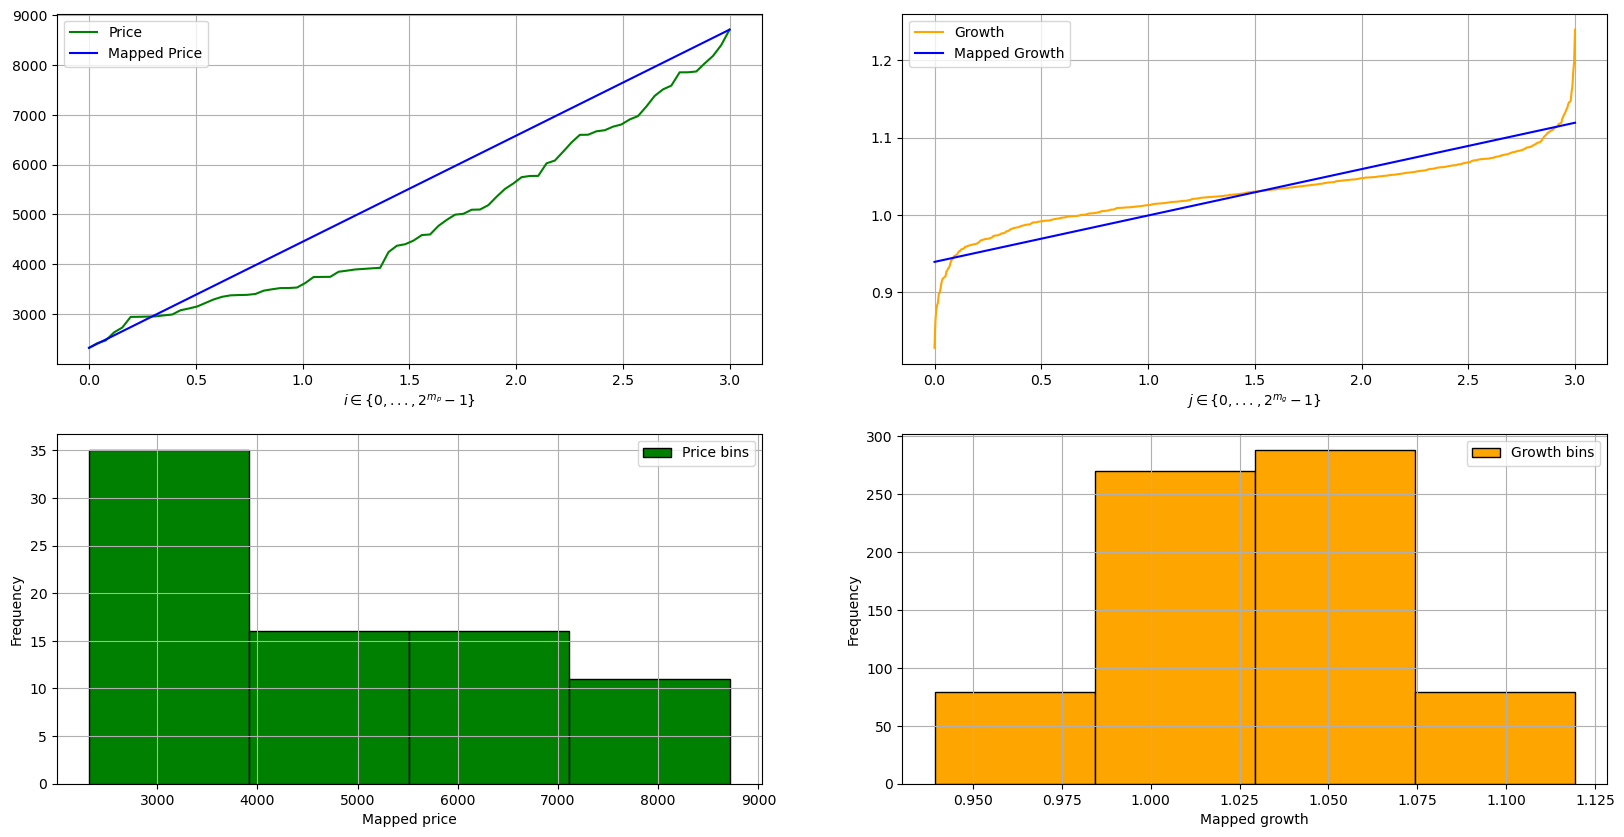

In [10]:
price_bins, price_probs = binning(price_data, price_qbits, price_domain[0], price_domain[1])
growth_bins, growth_probs = binning(growth_data, growth_qbits, growth_domain[0], growth_domain[1])

map_image = get_image(price_qbits, growth_qbits, price_domain, growth_domain)

g0, price_g1, growth_g1 = get_angles(price_qbits, growth_qbits, price_domain, growth_domain, c_rescale)

mapped_price = [linear_map(price_qbits, price_domain, x) for x in range(2**price_qbits)]
mapped_growth = [linear_map(growth_qbits, growth_domain, x) for x in range(2**growth_qbits)]

estimation_map = [linear_map(price_qbits, price_domain, x)*linear_map(growth_qbits, growth_domain, x) for x in range(2**price_qbits)]
estimation_scaled = [scaled_map(map_image, f) for f in estimation_map]


print(f" Price domain = {price_domain}")
print(f"Growth domain = {growth_domain}")
print()
print(f"Predicted price  = {map_image}")
print(f"Predicted price scaled between  = {[estimation_scaled[0], estimation_scaled[-1]]}")


rows = 2
cols = 2
fig, axs = plt.subplots(rows, cols)
fig.set_figwidth(20)
fig.set_figheight(10)

axs[0][0].plot(np.linspace(0, 2**price_qbits-1, len(price_data)), sorted(price_data), color='green', label='Price')
axs[0][1].plot(np.linspace(0, 2**growth_qbits-1, len(growth_data)), sorted(growth_data), color='orange', label='Growth')
axs[0][0].plot(range(0, 2**price_qbits), mapped_price, color='blue', label='Mapped Price')
axs[0][1].plot(range(0, 2**growth_qbits), mapped_growth, color='blue', label='Mapped Growth')
    
axs[1][0].hist(price_data, price_bins, color='green', label='Price bins', ec = 'black')
axs[1][1].hist(growth_data, growth_bins, color='orange', label='Growth bins', ec = 'black')

axs[0][0].set_xlabel('$i \\in \\{0,...,2^{m_{p}} - 1 \\}$')
axs[0][1].set_xlabel('$j \\in \\{0,...,2^{m_{g}} - 1 \\}$')
axs[1][0].set_xlabel('Mapped price')
axs[1][1].set_xlabel('Mapped growth')
axs[1][0].set_ylabel('Frequency')
axs[1][1].set_ylabel('Frequency')

for i in range(rows):
    for j in range(cols):
        axs[i][j].grid()
        axs[i][j].legend()
plt.show()

### Building gates

We define the P-gate to encode the binned data into the qubits. This can be done using the QR-decomposition and qiskits `UnitaryGate` method

In [11]:
def Build_P(m, p_list):
    matrix = np.identity(2**m)
    for i, p in enumerate(p_list):
        matrix[i][0] = np.sqrt(p)
    qr_matrix = np.linalg.qr(matrix)[0]
    P_gate =  UnitaryGate(qr_matrix, label='  P  ')
    circ = QuantumCircuit(m)
    circ.append(P_gate, list(range(m)))
    return circ

Rotations $R_y[g(i,j)]$, where $g(i,j) = g_0 + g(1,0)i + g(0,1)j $ can be be implemented by first applying $R_y(g_0)$ on the objective qubit, and then applying controlled rotations $R_y(2^i g_1)$, where control qubit is $|i\rangle$.

In [12]:
def Build_R(mp, mg, g0, p_g1, g_g1):
    circ = QuantumCircuit(mp+mg+1)
    circ.ry(g0, mg+mp)
    for i in range(mp):
        angle = (2**i) * p_g1
        circ.cry(angle, i, mp+mg)
    for i in range(mp, mp+mg):
        angle = (2**i) * g_g1
        circ.cry(angle, i, mp+mg)
    return circ

A-gate encodes the amplitude into the objective qubit, first by preparing the qubit registers $|i\rangle_{m_p}$ and $|j\rangle_{m_g}$ according to the price and growth probability distributions, and then by performing the Y-rotations on the objecive qubit.

In [13]:
def Build_A(mp, mg, p_list, g_list, g0, p_g1, g_g1):
    P_price = Build_P(mp, p_list)
    P_growth = Build_P(mg, g_list)
    R = Build_R(mp, mg, g0, p_g1, g_g1)
    circ = QuantumCircuit(mp+mg+1)
    circ.append(P_price, range(mp))
    circ.append(P_growth, range(mp, mp+mg))
    circ.append(R, range(mp+mg+1))
    return circ

The reflection $S_0$ of the all-zero state can be implemented with the multicontrolled $Z$-gate on the objective qubit surrounded by the $X$-gates. In qiskit, the multicontrolled $Z$-gate can be implemented with multicontrolled $X$-gate and Hadamard gates, as $Z = HXH$.

The reflection $S_\psi$ of the good state $|1\rangle$ can be implemented by applying $Z$-gate on the last qubit.


In [14]:
def Build_S_0(mp,mg):
    s0 = QuantumCircuit(mp+mg+1)
    s0.x(range(mp+mg+1))
    s0.h(mp+mg)
    s0.mcx(list(range(mp+mg)), mp+mg)
    s0.h(mp+mg)
    s0.x(range(mp+mg+1))
    return s0.to_gate(label='  S0  ')

def Build_S_psi0(mp, mg):
    circ = QuantumCircuit(mp+mg+1)
    circ.z(mp+mg)
    return circ.to_gate(label='  S_psi  ')

Grover operator implemented with $Q=AS_0A^{-1}S_{\psi}$

In [15]:
def Build_Q(mp, mg, A):
    S_0 = Build_S_0(mp, mg)
    S_psi = Build_S_psi0(mp, mg)
    A_inv = A.inverse()
    A_inv.label = '  A_inv  '
    circ = QuantumCircuit(mp+mg+1)
    circ.append(S_psi, range(mp+mg+1))
    circ.append(A_inv, range(mp+mg+1))
    circ.append(S_0, range(mp+mg+1))
    circ.append(A, range(mp+mg+1))
    return circ

### Building circuits and simulator

In [16]:
def Build_circuits(grovers, mp, mg, p_list, g_list, g0, p_g1, g_g1):
    qcs = []
    A = Build_A(mp, mg, p_list, g_list, g0, p_g1, g_g1).decompose().to_gate(label='  A  ')
    Q = Build_Q(mp, mg, A).to_instruction(label='  Q  ')
    for g in range(len(grovers)):
        req_dist = QuantumRegister(mp+mg, 'q')
        req_obj= QuantumRegister(1, 'b')
        req_classical = ClassicalRegister(1, 'c')
        circ = QuantumCircuit(req_dist, req_obj, req_classical)
        circ.append(A, range(0, mp+mg+1))
        circ.barrier()
        for times in range(grovers[g]):
            circ.append(Q, range(0, mp+mg+1))
        circ.measure(req_obj, req_classical)
        qcs.append(circ)
    return qcs

In [17]:
def simulator(qcs, shots, backend):
    hits = []
    job = execute(qcs, backend=backend, shots=shots, optimization_level=3, circuit_duration_check=False)
    counts = job.result().get_counts()
    for i in range(len(counts)):
        hits.append(counts[i].get("1",0))
    return hits

### Postprocessing

Maximum likelihood estimation

In [18]:
def loglikelihood(theta, g, hits, grovers, shots):
    value = 0.0
    for i in range(g + 1):
        arg = (2*grovers[i] + 1) * theta
        value += hits[i]*np.log(np.sin(arg)**2) + (shots[i] - hits[i])*np.log(np.cos(arg)**2)
        #The factor -1 as we want to maximize the function
    return -1*value

In [19]:
def error_rate(N, grovers, shots, p0):
    Fischer = 0.0
    for i in range(N+1):
        Fischer += shots[i]/(p0*(1 - p0)) * (2*grovers[i] + 1)**2
    error = np.sqrt(1/Fischer)
    return error

In [20]:
def ml_estimation(hits, grovers, shots):
    thetas = []
    #Small parameter to avoid dividing with zero
    epsilon = 10**-15
    #Adjusting confidence affects the search ranges when minimizing he function
    confindence = 1
    range_min = 0.0 + epsilon
    range_max = pi/2 - epsilon
    for g in range(len(grovers)):
        searchRange = (range_min, range_max)
        r = optimize.brute(lambda x: loglikelihood(x, g, hits, grovers, shots), [searchRange], finish=None)
        theta0 = r
        thetas.append(theta0)
        p0 = np.sin(theta0)**2
        p_error = error_rate(g, grovers, shots, p0)
        theta_error = np.arcsin(np.sqrt(p_error))
        range_min = max(theta0 - confindence*theta_error , 0.0 + epsilon)
        range_max = min(theta0 + confindence*theta_error , pi/2 - epsilon)
    return thetas

Expected price given by taylor approximation of the measured amplitude $P_1$, and reverting the scaling.

In [21]:
def Expected(a_tilde, image, rescaling):
    c, d = image
    scaled = (a_tilde-0.5)/rescaling
    value = 0.5*((scaled + 1)*(d - c) + c)
    return value

In [22]:
def Oracle_Calls(N, grovers, shots):
    value = 0
    for i in range(N+1):
        value += shots[i]*(2*grovers[i] + 1)
    return value

### Running the simulation and printing the results

In [23]:
#Building circuits
start = time.time()
qcs = Build_circuits(grover_list, price_qbits, growth_qbits, price_probs, growth_probs, g0, price_g1, growth_g1)
end = time.time()
print(f"      Building time = {end - start}")

#Simulation
start = time.time()
hitlist = simulator(qcs, shot_amount, backend_simulator)
    
end = time.time()
print(f"    Simulation time = {end - start}")

#Postprocessing
start = time.time()
thetas = ml_estimation(hitlist, grover_list, shot_list)
amps = np.sin(thetas)**2
all_answers = Expected(amps, map_image, c_rescale)

final_answer = all_answers[-1]
end = time.time()
print(f"Postprocessing time = {end - start}")
print()

#Printing results
print(f"     Price Qubits: {price_qbits}")
print(f"    Growth Qubits: {growth_qbits}")
print(f"     Total Qubits: {price_qbits + growth_qbits + 1}")
print(f"Shots per circuit: {shot_amount}")
print(f"    Grover scheme: {grover_list}")
print()
print(f"           Hits: {hitlist}")
print(f"         Thetas: {thetas}")
print(f"   Amplitudes: : {amps}")
print(f"Expected prices: {all_answers}")
print()
print(f"  Classical result = {classical_result}")
print(f"    Quantum result = {final_answer}")
print(f"        Difference = {final_answer - classical_result}")
print(f"Total Oracle calls = {Oracle_Calls(grover_amount-1, grover_list, shot_list)}")

      Building time = 0.018660306930541992
    Simulation time = 9.555940866470337
Postprocessing time = 0.002608776092529297

     Price Qubits: 2
    Growth Qubits: 2
     Total Qubits: 5
Shots per circuit: 100
    Grover scheme: [0, 1, 2, 3]

           Hits: [57, 57, 59, 44]
         Thetas: [0.8267349088394191, 0.7674924607096731, 0.8006599465449824, 0.7958156962030203]
   Amplitudes: : [0.54128967 0.48209812 0.51525941 0.51041678]
Expected prices: [5501.34418002 4604.81299979 5107.08284128 5033.7349946 ]

  Classical result = 5009.88136031182
    Quantum result = 5033.734994596174
        Difference = 23.853634284354484
Total Oracle calls = 1600


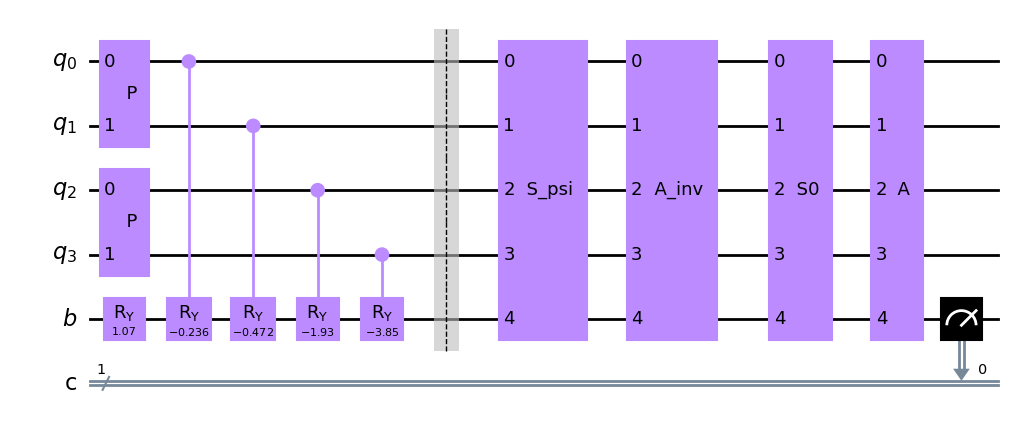

In [24]:
qcs[1].decompose(reps=1).draw('mpl', style="clifford")